# Solving an ODE using neural networks 

I'm very new to deep learning (coming from a math PDE background), but I'm trying to solve some ODEs using a neural network (via tensorflow). I've solved some simple ones like $𝑢^{'}(𝑥)+𝑢(𝑥)=𝑓(𝑥)$  with no problem, but I'm trying something a bit harder now: $𝑢^{"}(𝑥)−𝑥𝑢(𝑥)=0$ with the initial conditions $𝑢(0)=𝐴$ and $𝑢^{'}(0)=𝐵$

I'm mostly following this paper, and my solution is written as $$𝑢_𝑁(𝑥)=𝐴+𝐵𝑥+𝑥^{2}𝑁(𝑥,\omega),$$
where $𝑁(𝑥,\omega)$ is the output of the neural net. The loss function I'm using is just the residual of the ODE in a mean square sense, so it's pretty crude: $$l(𝑥,\omega)=\sum^𝑁_{𝑗=1}(𝑢_𝑁^{"}(𝑥)−𝑥𝑢_𝑁(𝑥))^2.$$
I'm having a lot of trouble getting a good numerical solution to this particular equation. You can see a typical result below (orange is the exact solution, blue is my solution).

My current setup is just 2 hidden layers of 400 nodes each (one leaky ReLU and one ReLU) followed by a linear activation layer. My input data is an evenly spaced discretization of the domain. I'm using the Adam optimizer with a batch size of 32 and run for 400 epochs. I can't seem to capture the oscillating behavior in the left of the domain properly no matter what parameters I tweak.

Does anyone have any suggestions for how to improve the result? I'm very very new to deep learning and neural networks. If it helps, my code is included below. I should also probably give credit to Emm and vijay m, whose code for 1D approximation was the base for my code



In [1]:
import tensorflow as tf
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy import special

2023-12-28 09:53:14.221571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 09:53:14.450606: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 09:53:15.133520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/home/sidney/anaconda3/envs/tf/lib/
2023-12-28 09:53:15.133620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerr

In [2]:
######################################################################
# Routine to solve u''(x) - x*u(x) = f(x), u(0)=A, u'(0)=B in the form
#     u(x) = A + B*x + x^2*N(x,w)
# where N(x,w) is the output of the neural network.
######################################################################


In [25]:
# Create the arrays x and y, where x is a discretization of the domain (a,b) and y is the source term f(x)
N = 500
a = -6.0
b = 2.0
x = np.arange(a, b, (b-a)/N).reshape((N,1))
y = np.zeros(N)

# Boundary conditions
A = 1.0
B = 0.0

In [46]:
# Define the number of neurons in each layer
n_nodes_hl1 = 100
n_nodes_hl2 = 50
n_nodes_hl3 = 25
# Define the number of outputs and the learning rate
n_classes = 1 #saida linear
learn_rate = 0.001

## Placeholders


Até agora usamos Variáveis para gerenciar nossos dados, mas existe uma estrutura mais básica, o placeholder. Um espaço reservado é simplesmente uma variável à qual atribuiremos dados posteriormente. Ele nos permite criar nossas operações e construir nosso gráfico de computação, sem precisar dos dados. Na terminologia do TensorFlow, alimentamos dados no gráfico por meio desses espaços reservados.


In [55]:
# Define input / output placeholders
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
x_ph = tf.placeholder('float', [None, 1],name='input')
y_ph = tf.placeholder('float')

In [119]:
# Define standard deviation for the weights and biases
hl_sigma = 0.02
# Routine to compute the neural network (5 hidden layers)
def neural_network_model(data):
    hidden_1_layer = {'weights': tf.Variable(name='w_h1',initial_value=tf.random_normal([1, n_nodes_hl1], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h1',initial_value=tf.random_normal([n_nodes_hl1], stddev=hl_sigma))}

    hidden_2_layer = {'weights': tf.Variable(name='w_h2',initial_value=tf.random_normal([n_nodes_hl1, n_nodes_hl2], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h2',initial_value=tf.random_normal([n_nodes_hl2], stddev=hl_sigma))}
    

    hidden_3_layer = {'weights': tf.Variable(name='w_h3',initial_value=tf.random_normal([n_nodes_hl2, n_nodes_hl3], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h3',initial_value=tf.random_normal([n_nodes_hl3], stddev=hl_sigma))}

    output_layer = {'weights': tf.Variable(name='w_o',initial_value=tf.random_normal([n_nodes_hl3, n_classes], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_o',initial_value=tf.random_normal([n_classes], stddev=hl_sigma))}


    # (input_data * weights) + biases
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    #l1 = tf.nn.leaky_relu(l1)   
    l1 = tf.nn.sigmoid(l1)

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    #l2 = tf.nn.relu(l2)
    l2 = tf.nn.sigmoid(l2)

    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    #l2 = tf.nn.relu(l2)
    l3 = tf.nn.sigmoid(l3)

    output = tf.add(tf.matmul(l3, output_layer['weights']), output_layer['biases'], name='output')

    return output

In [120]:
batch_size = 32

# Feed batch data
def get_batch(inputX, inputY, batch_size):
    duration = len(inputX)
    for i in range(0,duration//batch_size):
        idx = i*batch_size + np.random.randint(0,10,(1))[0]

        yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size]

In [121]:
# Routine to train the neural network
def train_neural_network_batch(x_ph, predict=False):
    Loss = []
    Epoca = []
    #u_N(x)
    prediction = neural_network_model(x_ph)
    #du_N/dt
    pred_dx = tf.gradients(prediction, x_ph)
    #d^2u_N/dt²
    pred_dx2 = tf.gradients(tf.gradients(prediction, x_ph),x_ph)

    # Compute u and its second derivative
    u = A + B*x_ph + (x_ph*x_ph)*prediction
    
    dudx2 = (x_ph*x_ph)*pred_dx2 + 2.0*x_ph*pred_dx + 2.0*x_ph*pred_dx + 2.0*prediction

    # The cost function is just the residual of u''(x) - x*u(x) = 0, i.e. residual = u''(x)-x*u(x)
    cost = tf.reduce_mean(tf.square(dudx2 - x_ph*u - y_ph))
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(cost)


    # cycles feed forward + backprop
    hm_epochs =400

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Train in each epoch with the whole data
        for epoch in range(hm_epochs):

            epoch_loss = 0
            for step in range(N//batch_size):
                for inputX, inputY in get_batch(x, y, batch_size):
                    _, l = sess.run([optimizer,cost], feed_dict={x_ph:inputX, y_ph:inputY})
                    epoch_loss += l
            if epoch %10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', epoch_loss)
                Loss.append(epoch_loss)
                Epoca.append(epoch)

        # Predict a new input by adding a random number, to check whether the network has actually learned
        x_valid = x + 0.0*np.random.normal(scale=0.1,size=(1))
        return sess.run(tf.squeeze(prediction),{x_ph:x_valid}), x_valid,Epoca,Loss

In [122]:
# Train network
tf.set_random_seed(42)
pred, time,Epoca,Loss= train_neural_network_batch(x_ph)


2023-12-28 11:38:17.436675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:38:17.437374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:38:17.437636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:38:17.437964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:38:17.438220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 0 completed out of 400 loss: 28.606400793854846
Epoch 10 completed out of 400 loss: 0.12956019445982747
Epoch 20 completed out of 400 loss: 0.14350126025306054
Epoch 30 completed out of 400 loss: 0.18729270273570364
Epoch 40 completed out of 400 loss: 0.5584821741847463
Epoch 50 completed out of 400 loss: 0.3726798663544173
Epoch 60 completed out of 400 loss: 0.11164105146774261
Epoch 70 completed out of 400 loss: 0.025041186640692104
Epoch 80 completed out of 400 loss: 0.11656674791757382
Epoch 90 completed out of 400 loss: 0.32462629690098765
Epoch 100 completed out of 400 loss: 0.3236410089890569
Epoch 110 completed out of 400 loss: 0.37327261862446903
Epoch 120 completed out of 400 loss: 0.34180385127547197
Epoch 130 completed out of 400 loss: 0.247430408729997
Epoch 140 completed out of 400 loss: 0.2881262763075938
Epoch 150 completed out of 400 loss: 0.8117034320384846
Epoch 160 completed out of 400 loss: 0.16460590628184946
Epoch 170 completed out of 400 loss: 0.0294515346

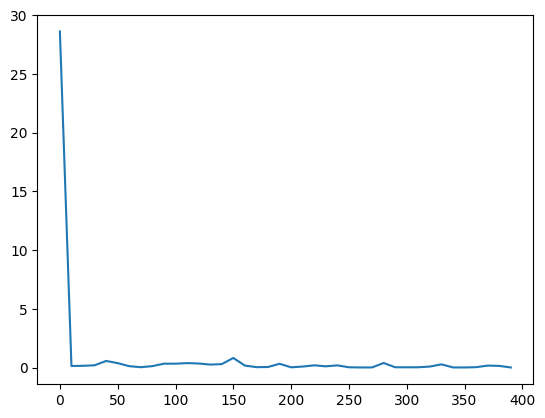

In [125]:
plt.plot(Epoca,Loss)
#plt.ylim(0,2)

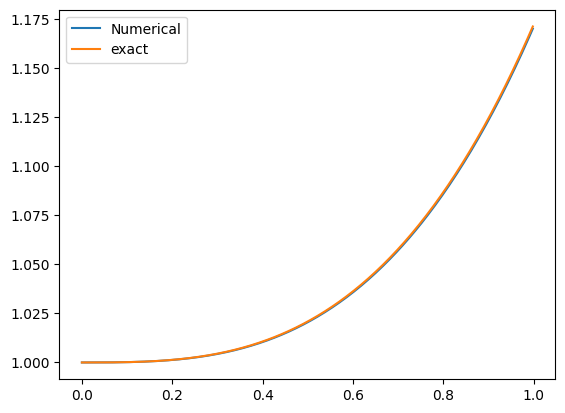

In [126]:
mypred = pred.reshape(N,1)

# Compute Airy functions for exact solution
ai, aip, bi, bip = special.airy(time)

# Numerical solution vs. exact solution
fig = plt.figure()
plt.plot(time, A + B*time + (time*time)*mypred,label='Numerical')
plt.plot(time, 0.5*(3.0**(1/6))*special.gamma(2/3)*(3**(1/2)*ai + bi),label='exact')
plt.legend()
plt.show()

# Setting up the problem
Here, we will model a population f(t) in an environment having carrying capacity A. The population follows the model

 
$$ \dfrac{df(t)}{dt} = \alpha f(A - f(t))$$
 
where $f(0)=f_0$.

In this example, we let $a=2$, A = 1 and $f_0=1.2$.

## The trial solution
We will get a slightly different trial solution, as the boundary conditions are different compared to the case for exponential decay.

A possible trial solution satisfying the condition $f(0)=f_0$. could be

 
$$ f_N(t)=f_0+t⋅N(t,P)$$
 
with $N(t,P)$ being the output from the neural network with weights and biases for each layer collected in the set $P$.

The analytical solution is
$$ f(t)=\dfrac{Ag_0}{g_0+(A−g_0)\exp(−\alpha At)}$$
 
 

In [37]:
# Define input / output placeholders
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
x_ph = tf.placeholder('float', [None, 1],name='input')
y_ph = tf.placeholder('float')

In [52]:
# Create the arrays x and y, where x is a discretization of the domain (a,b) and y is the source term f(x)
N = 500
a = 0
b = 1

alpha = 2
x = np.arange(a, b, (b-a)/N).reshape((N,1))
y = np.zeros(N)

# Boundary conditions
A = 1.0
f0 = 1.2

In [96]:
# Define the number of neurons in each layer
n_nodes_hl1 = 100
n_nodes_hl2 = 50
n_nodes_hl3 = 25
# Define the number of outputs and the learning rate
n_classes = 1 #saida linear
learn_rate = 0.001

In [128]:
# Define input / output placeholders
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
x_ph = tf.placeholder('float', [None, 1],name='input')
y_ph = tf.placeholder('float')

In [101]:
# Define standard deviation for the weights and biases
hl_sigma = 0.02
# Routine to compute the neural network (5 hidden layers)
def neural_network_model(data):
    hidden_1_layer = {'weights': tf.Variable(name='w_h1',initial_value=tf.random_normal([1, n_nodes_hl1], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h1',initial_value=tf.random_normal([n_nodes_hl1], stddev=hl_sigma))}

    hidden_2_layer = {'weights': tf.Variable(name='w_h2',initial_value=tf.random_normal([n_nodes_hl1, n_nodes_hl2], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h2',initial_value=tf.random_normal([n_nodes_hl2], stddev=hl_sigma))}
    

    hidden_3_layer = {'weights': tf.Variable(name='w_h3',initial_value=tf.random_normal([n_nodes_hl2, n_nodes_hl3], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_h3',initial_value=tf.random_normal([n_nodes_hl3], stddev=hl_sigma))}

    output_layer = {'weights': tf.Variable(name='w_o',initial_value=tf.random_normal([n_nodes_hl3, n_classes], stddev=hl_sigma)),
                      'biases': tf.Variable(name='b_o',initial_value=tf.random_normal([n_classes], stddev=hl_sigma))}


    # (input_data * weights) + biases
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    #l1 = tf.nn.leaky_relu(l1)   
    l1 = tf.nn.sigmoid(l1)

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    #l2 = tf.nn.relu(l2)
    l2 = tf.nn.sigmoid(l2)

    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    #l2 = tf.nn.relu(l2)
    l3 = tf.nn.sigmoid(l3)

    output = tf.add(tf.matmul(l3, output_layer['weights']), output_layer['biases'], name='output')

    return output

In [102]:
# Routine to train the neural network
def train_neural_network_batch(x_ph,alpha,f0, predict=False):
    Loss = []
    Epoca = []
    #u_N(x)
    prediction = neural_network_model(x_ph)
    #du_N/dt
    pred_dt = tf.gradients(prediction, x_ph)
    

    # Compute u and its second derivative
    u = f0 + x_ph*prediction
    
    dudt = x_ph*pred_dt +prediction

    # The cost function is just the residual of u''(x) - x*u(x) = 0, i.e. residual = u''(x)-x*u(x)
    cost = tf.reduce_mean(tf.square(dudt -alpha*u*(1 - u) ))
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(cost)


    # cycles feed forward + backprop
    hm_epochs =1000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Train in each epoch with the whole data
        for epoch in range(hm_epochs):

            epoch_loss = 0
            for step in range(N//batch_size):
                for inputX, inputY in get_batch(x, y, batch_size):
                    _, l = sess.run([optimizer,cost], feed_dict={x_ph:inputX, y_ph:inputY})
                    epoch_loss += l
            if epoch %10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss:', epoch_loss)
                Loss.append(epoch_loss)
                Epoca.append(epoch)

        # Predict a new input by adding a random number, to check whether the network has actually learned
        x_valid = x + 0.0*np.random.normal(scale=0.1,size=(1))
        return sess.run(tf.squeeze(prediction),{x_ph:x_valid}), x_valid,Epoca,Loss

In [103]:
# Train network
tf.set_random_seed(42)
pred, time,Epoca,Loss= train_neural_network_batch(x_ph,alpha,f0)

2023-12-28 11:14:37.094744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:14:37.095399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:14:37.095634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:14:37.095924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 11:14:37.096159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 0 completed out of 1000 loss: 6.855150154719013
Epoch 10 completed out of 1000 loss: 0.4707683363958495
Epoch 20 completed out of 1000 loss: 0.029917477652873004
Epoch 30 completed out of 1000 loss: 0.0454326769971658
Epoch 40 completed out of 1000 loss: 0.04835504995421047
Epoch 50 completed out of 1000 loss: 0.0443302001604593
Epoch 60 completed out of 1000 loss: 0.059415851133550746
Epoch 70 completed out of 1000 loss: 0.006869011094205568
Epoch 80 completed out of 1000 loss: 0.05419334714308377
Epoch 90 completed out of 1000 loss: 0.030663825929099886
Epoch 100 completed out of 1000 loss: 0.02308813946170929
Epoch 110 completed out of 1000 loss: 0.013345733586596964
Epoch 120 completed out of 1000 loss: 0.014705556981035706
Epoch 130 completed out of 1000 loss: 0.006855501939642017
Epoch 140 completed out of 1000 loss: 0.03824015314523166
Epoch 150 completed out of 1000 loss: 0.002332278158082124
Epoch 160 completed out of 1000 loss: 0.020091283005854166
Epoch 170 completed o

(0.0, 0.2)

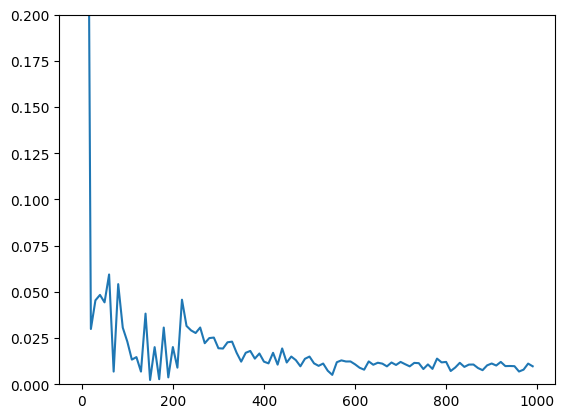

In [107]:
plt.plot(Epoca,Loss)
plt.ylim(0,0.2)

In [108]:
mypred = pred.reshape(N,1)

In [109]:
def get_parameters():
    alpha = 2
    A = 1
    g0 = 1.2
    return alpha, A, g0

In [110]:
def g_analytic(t):
    alpha,A, g0 = get_parameters()
    return A*g0/(g0 + (A - g0)*np.exp(-alpha*A*t))

In [111]:
SE = g_analytic(x)

(0.9, 1.25)

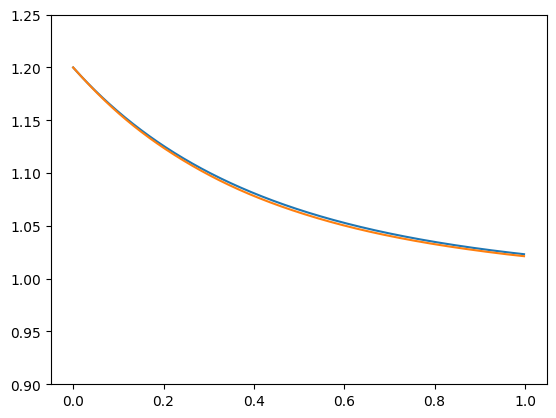

In [118]:
SE =SE.reshape(-1)
plt.plot(x,SE,label='Sol. exata")
plt.plot(x,f0+x*mypred, label='Sol. Numerica)
plt.ylim(0.9,1.25)
plt.legend()
plt.show()